In [1]:
import pandas as pd
from clickhouse_driver import Client
import matplotlib.pyplot as plt

# Подключеине к БД
try:
    db_client = Client(
        host='oleg.orbita.work',
        port=9000,
        user='student_ml',
        password='CGRV8zemLGgsfdz7Uc6ZJeisGTcPQa',
        settings={'use_numpy': True}
    )
    print("Успешно подключено к базе данных!")
except Exception as e:
    print(f"Ошибка подключения: {e}")
    exit()

Успешно подключено к базе данных!


In [2]:
# Загрузка данных из БД
try:
    sql_query = "SELECT * FROM students_datas.weather_history"
    weather_df = db_client.query_dataframe(sql_query)
    print(f"Данные загружены. Столбцы: {list(weather_df.columns)}")
except Exception as e:
    print(f"Во время загрузки базы данных произошла ошибка: {e}")
    exit()

Данные загружены. Столбцы: ['idx', 'year', 'month', 'day', 'min_t', 'average_t', 'max_t', 'rainfall']


In [3]:
# Обработка данных (удаление ненужных столбцов, проверка типов и их преобразование, 
if 'idx' in weather_df.columns:
    weather_df.drop(columns=['idx'], inplace=True)

required_cols = ['year', 'month', 'day', 'min_t', 'average_t', 'max_t', 'rainfall']
for col in required_cols:
    if col in weather_df.columns:
        if col in ['min_t', 'average_t', 'max_t', 'rainfall']:
            weather_df[col] = pd.to_numeric(weather_df[col], errors='coerce')
    else:
        print(f"Отсутствующие столбцы: {col}")

# Создание 'date' из года, месяца и дня
try:
    weather_df['date'] = pd.to_datetime(weather_df[['year', 'month', 'day']])
    print("Столбец 'date' создан!")
except Exception as e:
    print(f"Ошибка при создании даты: {e}")

Столбец 'date' создан!


In [4]:
# Анализ пропущенных значений
print("\nАнализ пропущенных значений:")
print(weather_df.isnull().sum())


Анализ пропущенных значений:
year           0
month          0
day            0
min_t        255
average_t    245
max_t        769
rainfall     258
date           0
dtype: int64


In [5]:
# Рассчёт температурного диапазона
if all(c in weather_df.columns for c in ['max_t', 'min_t']):
    weather_df['temp_range'] = weather_df['max_t'] - weather_df['min_t']
    print("Диапазон температур рассчитан")

# Рассчывание сухих периодов
if 'rainfall' in weather_df.columns:
    weather_df['days_without_rain'] = 0
    for i in range(1, len(weather_df)):
        if pd.notna(weather_df.loc[i, 'rainfall']) and weather_df.loc[i, 'rainfall'] == 0:
            weather_df.loc[i, 'days_without_rain'] = weather_df.loc[i-1, 'days_without_rain'] + 1
    print(f"Самый продолжительный сухой период: {weather_df['days_without_rain'].max()} days")

Диапазон температур рассчитан
Самый продолжительный сухой период: 27 days



Yearly statistics:
      avg_temperature  total_rainfall
year                                 
1960        -0.122740           458.7
1961         2.351524           517.4
1962         3.173130           367.5
1963         3.522626           430.3
1964         2.291160           424.4
...               ...             ...
2016         3.053867           482.7
2017         3.460724           497.2
2018         1.631944           442.4
2019         3.322992           375.4
2020         4.766758           435.7

[61 rows x 2 columns]

Самый теплый год: 2020 (4.8°C)
Самый холодный год 1969 (-0.6°C)


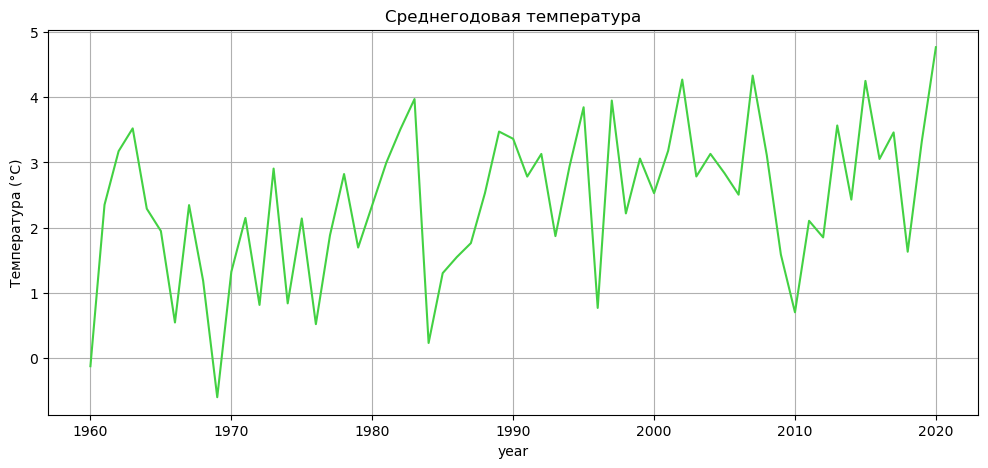


Самый дождливый год: 1970 (560.2 mm)
Самый сухой год: 1973 (258.0 mm)


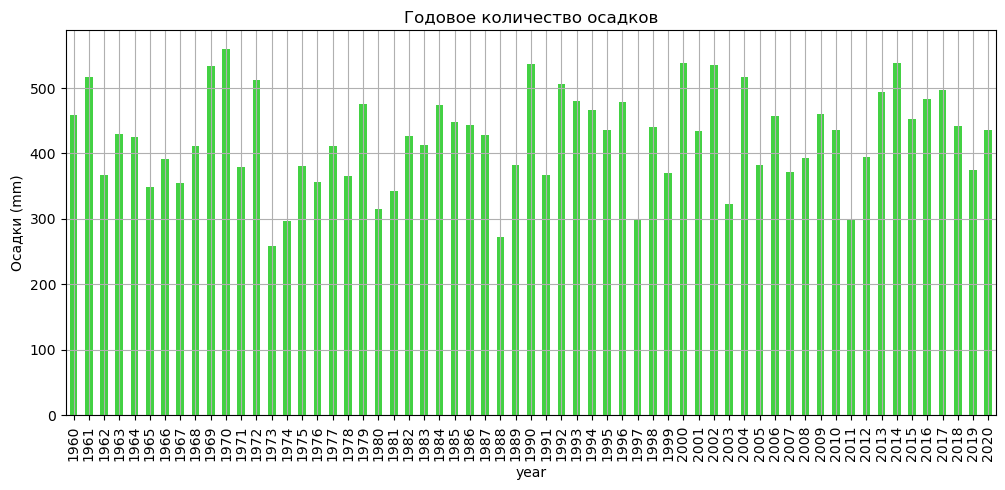

In [6]:
# Ежегодный статистический анализ
if all(c in weather_df.columns for c in ['year', 'average_t', 'rainfall']):
    yearly_statistics = weather_df.groupby('year').agg({
        'average_t': 'mean',
        'rainfall': 'sum'
    }).rename(columns={
        'average_t': 'avg_temperature',
        'rainfall': 'total_rainfall'
    })

    print("\nYearly statistics:")
    print(yearly_statistics)

    # Температурный анализ
    if 'avg_temperature' in yearly_statistics.columns:
        warmest = yearly_statistics['avg_temperature'].idxmax()
        coldest = yearly_statistics['avg_temperature'].idxmin()
        print(f"\nСамый теплый год: {warmest} ({yearly_statistics['avg_temperature'].max():.1f}°C)")
        print(f"Самый холодный год {coldest} ({yearly_statistics['avg_temperature'].min():.1f}°C)")

        # Визуализация температуры
        plt.figure(figsize=(12, 5))
        yearly_statistics['avg_temperature'].plot(title='Среднегодовая температура', color='#43d143')
        plt.ylabel('Температура (°C)')
        plt.grid()
        plt.show()

    # Анализ осадков и их визуализация
    if 'total_rainfall' in yearly_statistics.columns:
        wettest = yearly_statistics['total_rainfall'].idxmax()
        driest = yearly_statistics['total_rainfall'].idxmin()
        print(f"\nСамый дождливый год: {wettest} ({yearly_statistics['total_rainfall'].max():.1f} mm)")
        print(f"Самый сухой год: {driest} ({yearly_statistics['total_rainfall'].min():.1f} mm)")
        
        plt.figure(figsize=(12, 5))
        yearly_statistics['total_rainfall'].plot.bar(title='Годовое количество осадков', color='#43d143')
        plt.ylabel('Осадки (mm)')
        plt.grid()
        plt.show()

In [7]:
# Фильтр экстремальных значений
print("\nКрайние значения:")
if 'average_t' in weather_df.columns:
    cold_days = weather_df[weather_df['average_t'] < -30]
    print(f"Дни ниже -30°C: {len(cold_days)}")

if all(c in weather_df.columns for c in ['average_t', 'days_without_rain']):
    hot_dry = weather_df[(weather_df['average_t'] > 27) & (weather_df['days_without_rain'] > 3)]
    print(f"Жаркие и сухие периоды: {len(hot_dry)}")


Крайние значения:
Дни ниже -30°C: 241
Жаркие и сухие периоды: 11
